# Ranking by neural network

## Explanation

We want to train to rank pairs of data. The data can be anything but we know before hand how we want them to be ranked. For example if the data are `[[x11,x21],[x12,x22],[x13,x23],...]`  we will feed this data to the nn model and require that the model scores the data so that s1<s2. So always the second data point is selected. 

Of course these data need to be differentiable. In simple example below this is achieved by drawing two random samples and them adding a $1$ to one them so that they are differentiable, i.e. we can distinguish between them. 
```python
data_a = np.random.rand(10, n_features) + 1
data_b = np.random.rand(10, n_features)
```

The nn model will learn a utility function that will give a ranking score for any data point. This is demonstrated in the `visualize_results` function and specifically
```python
scores_test = sess.run(s1, feed_dict={x1:data_test, dropout_keep_prob:1})
```
The same approach can be used to learn to score any data. For example if we have video footage of a task, like folding clothes, we can learn a nn model that ranks each next frame higher than the previous since we are reaching closer to the goal of having a folded cloth.

The rest of the code below is relatively straight-forward

## Code

Import the relevant libraries

In [1]:
import tensorflow as tf
import numpy as np
import random

%matplotlib inline
import matplotlib.pyplot as plt

np.random.seed(1)

Let's fabricate some data. We'll call `get_data()` to generate two datasets: `data_a` and `data_b`.

We'll use the convention that points in `data_a` are ranked lower than those in `data_b`. So we need to learn a ranking function (i.e. utility function) that scores points in `data_a` lower. 

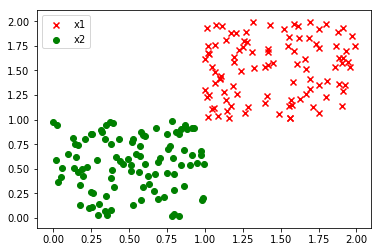

In [2]:
n_features = 2

def get_data():    
    data_a = np.random.rand(100, n_features) + 1
    data_b = np.random.rand(100, n_features)
    
    plt.scatter(data_a[:, 0], data_a[:, 1], 
                c='r', marker='x',label='x1')
    plt.scatter(data_b[:, 0], data_b[:, 1], 
                c='g', marker='o',label='x2')
    plt.legend()
    plt.show()
    
    return data_a, data_b

data_a, data_b = get_data()

Now, let's define our ranking model. It'll take in two items (`x1` and `x2`), and return a score (`s1` and `s2`) for each item. 

Our model introduces a hyper-parameter called `n_hidden` to tweak the number of neurons in the hidden layer of the network.

In [3]:
n_hidden = 10

When defining the model, let's organize it into separate scopes. That way, the TensorBoard visualization will look very clean.

In [4]:
with tf.name_scope("input"):
    x1 = tf.placeholder(tf.float32, 
                        [None, n_features], name="x1")
    x2 = tf.placeholder(tf.float32, 
                        [None, n_features], name="x2")
    dropout_keep_prob = tf.placeholder(tf.float32, 
                                       name='dropout_prob')


with tf.name_scope("hidden_layer"):
    with tf.name_scope("weights"):
        w1 = tf.Variable(tf.random_normal([n_features, 
                                           n_hidden]), 
                         name="w1")
        tf.summary.histogram("w1", w1)
        b1 = tf.Variable(tf.random_normal([n_hidden]), 
                         name="b1")
        tf.summary.histogram("b1", b1)
 
    with tf.name_scope("output"):
        h1 = tf.nn.dropout(tf.nn.relu(tf.matmul(x1,w1) + b1), 
                           keep_prob=dropout_keep_prob)
        tf.summary.histogram("h1", h1)
        h2 = tf.nn.dropout(tf.nn.relu(tf.matmul(x2, w1) + b1), 
                           keep_prob=dropout_keep_prob)
        tf.summary.histogram("h2", h2)
 

with tf.name_scope("output_layer"):
    with tf.name_scope("weights"):
        w2 = tf.Variable(tf.random_normal([n_hidden, 1]), name="w2")
        tf.summary.histogram("w2", w2)
        b2 = tf.Variable(tf.random_normal([1]), name="b2")
        tf.summary.histogram("b2", b2)
 
    with tf.name_scope("output"):
        # matrix multiplication
        s1 = tf.matmul(h1, w2) + b2
        s2 = tf.matmul(h2, w2) + b2
        # with tf.nn.sigmoid scores are restricted [0,1]
        # s1 = tf.nn.sigmoid(tf.matmul(h1, w2) + b2)
        # s2 = tf.nn.sigmoid(tf.matmul(h2, w2) + b2)

The loss function will involve comparing `s1` and `s2`. 

Since we're trying to acheive the inequality `Score(x1) < Score(x2)`, we need the loss function to insinuate `s1 < s2`. 

In other words, the loss function tries to guarantee that `s1 - s2 < 0`. 
In the loss function we want to have `tf.zeros(s1-s2)` to be equal to `s1-s2+1`. For $s_{1}-s_{2}+1=0$ it follows $s_{1}-s_{2}<0$ which is our goal.

In [5]:
with tf.name_scope("loss"):
    s12 = s1 - s2
    s12_flat = tf.reshape(s12, [-1])
       
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
        labels=tf.zeros_like(s12_flat),                                             
        logits=s12_flat + 1)
    loss = tf.reduce_mean(cross_entropy)
    tf.summary.scalar("loss", loss)
 
with tf.name_scope("train_op"):
    train_op = tf.train.AdamOptimizer(0.001).minimize(loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



Start the session and prepare peripheral ops.

In [6]:
sess = tf.InteractiveSession()
summary_op = tf.summary.merge_all()
writer = tf.summary.FileWriter("tb_files", sess.graph)
init = tf.global_variables_initializer()
sess.run(init)

Train the model with the training data.

In [7]:
for epoch in range(0, 10000):
    loss_val, _ = sess.run([loss, train_op], 
                           feed_dict={x1:data_a, x2:data_b, 
                                      dropout_keep_prob:0.5})
    if epoch % 100 == 0 :
        summary_result = sess.run(summary_op, 
                                  feed_dict={x1:data_a, x2:data_b, 
                                             dropout_keep_prob:1})
        writer.add_summary(summary_result, epoch)

Visualize the results on a grid by accumulating a list of points to test.

In [8]:
grid_size = 100
data_test = []
for y in np.linspace(0., 1., num=grid_size):
    for x in np.linspace(0., 1., num=grid_size):
        data_test.append([x, y])

Run the model on all the test points and visualize the utility scores of each point by a color.

In [9]:
def visualize_results(data_test):
    plt.figure()
    scores_test = sess.run(s1, 
                           feed_dict={x1:data_test, dropout_keep_prob:1})
    scores_img = np.reshape(scores_test, [grid_size, grid_size])
    plt.imshow(scores_img, origin='lower')
    plt.colorbar()

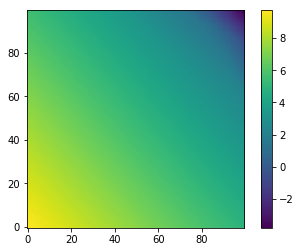

In [10]:
visualize_results(data_test)

So the area with the $x_{2}$ points (lower left) has higher utility than the lower utility top right corner.